In [1]:
import numpy as np
import torch
import torchvision
import torchmetrics
import lightning.pytorch as pl 
from torchinfo import summary 
from torchview import draw_graph 
import matplotlib.pyplot as plt 
import pandas as pd

if (torch.cuda.is_available()): 
    device = ("cuda")
else:
    device = ("cpu")
print(f"Use GPU: {torch.cuda.is_available()}")

Use GPU: True


In [15]:
# Config Section
cfg_data_folder = "datasets/cifar10"
cfg_max_epochs  = 50;
cfg_num_workers = 2
cfg_hidden_dims = 34
cfg_num_hidden_layers = 18

cfg_logger_dir="logs"
cfg_logger_name="OL2"
cfg_logger_version="resid"

cfg_cifar10_labels = {
  0: "Airplane",
  1: "Automobile",
  2: "Bird",
  3: "Cat",
  4: "Deer",
  5: "Dog",
  6: "Frog",
  7: "Horse",
  8: "Ship",
  9: "Truck",
}

In [16]:
# Load the data set and scale to [-1,+1]
training_dataset = torchvision.datasets.CIFAR10(root=cfg_data_folder, download=True, train=True)
testing_dataset = torchvision.datasets.CIFAR10(root=cfg_data_folder,  download=True, train=False) 

x_train = (torch.Tensor(training_dataset.data) / 127.5) - 1.0
y_train = torch.Tensor(training_dataset.targets).to(torch.long)
x_test = (torch.Tensor(testing_dataset.data) / 127.5) - 1.0 
y_test = torch.Tensor(testing_dataset.targets).to(torch.long)

# You can set a seed value here if you
# want to control the shuffling process...
rng = np.random.default_rng()
permutation = rng.permutation(x_train.shape[0]) 
split_point = int(x_train.shape[0] * 0.8) # 80%/20% split

# Split into validation/training - keep test # set aside for later...
x_val = x_train[permutation][split_point:]
y_val = y_train[permutation][split_point:]
x_train = x_train[permutation][:split_point]
y_train = y_train[permutation][:split_point]

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([40000, 32, 32, 3])
torch.Size([10000, 32, 32, 3])
torch.Size([10000, 32, 32, 3])


In [17]:
x_train.shape

torch.Size([40000, 32, 32, 3])

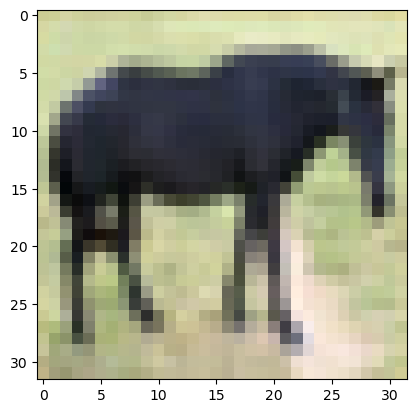

Label: Horse (idx: 7)


In [18]:
plt.imshow((x_train[0].detach().numpy() + 1.0)/2.0)
plt.show()
print(f"Label: {cfg_cifar10_labels.get(int(y_train[0]))} (idx: {y_train[0]})")

In [19]:
# Define residual layer
class ResidualLayer(torch.nn.Module): 
    def __init__(self, hidden_size, **kwargs):
        super().__init__(**kwargs)
        self.residual = torch.nn.Linear(hidden_size, hidden_size)
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        y = x
        y = self.activation(self.residual(y))
        y = y + x # Add residual
        return y

In [20]:
class ResidualNetwork(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_hidden_layers, **kwargs):
        super().__init__(**kwargs)
        self.flatten_layer = torch.nn.Flatten()
        
        # Initial linear projection
        layers = [torch.nn.Linear(input_size.numel(), hidden_size),
                  torch.nn.ReLU(),
                  torch.nn.BatchNorm1d(hidden_size),
                  torch.nn.Dropout(0.5)
                 ]
        for _ in range(num_hidden_layers):
            layers.append(ResidualLayer(hidden_size))
            layers.append(torch.nn.ReLU())  # Use ReLU activation
            layers.append(torch.nn.BatchNorm1d(hidden_size))  # Add Layer Normalization

        self.hidden_layers = torch.nn.Sequential(*layers)
        self.output_layer = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        y = x
        y = self.flatten_layer(y)
        y = self.hidden_layers(y)
        y = self.output_layer(y)
        return y
        
    def predict(self, x):
        y = x
        y = self.forward(y)
        y = torch.softmax(y, -1)
        return y

In [21]:
# Define Trainable Module
class PLModel(pl.LightningModule):
    def __init__(self, module, **kwargs):
        # This is the contructor, where we typically make
        # layer objects using provided arguments. 
        super().__init__(**kwargs) # Call the super class constructor 
        self.module = module
        
        # This creates an accuracy function
        self.model_acc = torchmetrics.classification.Accuracy(task='multiclass', 
                                                              num_classes=module.output_layer.out_features)
        # This creates a loss function
        self.model_loss = torch.nn.CrossEntropyLoss()
    
    def forward(self, x):
        return self.module.forward(x) 
        
    def predict(self, x):
        return self.module.predict(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-4)
        return optimizer

    def training_step(self, train_batch, batch_idx): 
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred, y_true)
        loss = self.model_loss(y_pred, y_true) 
        self.log('train_acc',  acc,  on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True) 
        return loss


    def validation_step(self, val_batch, batch_idx): 
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred, y_true)
        loss = self.model_loss(y_pred, y_true)
        self.log('val_acc',  acc,  on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
        
    def test_step(self, test_batch, batch_idx):
        x, y_true = test_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred,y_true)
        loss = self.model_loss(y_pred,y_true)
        self.log('test_acc',  acc,  on_step=False, on_epoch=True)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return loss


In [22]:
model = PLModel(ResidualNetwork(x_train.shape[1:],
                                len(y_train.unique()),
                                cfg_hidden_dims,
                                cfg_num_hidden_layers))

summary(model, input_size=(1,)+x_train.shape[1:])

Layer (type:depth-idx)                   Output Shape              Param #
PLModel                                  [1, 10]                   --
├─ResidualNetwork: 1-1                   --                        --
│    └─Flatten: 2-1                      [1, 3072]                 --
│    └─Sequential: 2-2                   [1, 34]                   --
│    │    └─Linear: 3-1                  [1, 34]                   104,482
│    │    └─ReLU: 3-2                    [1, 34]                   --
│    │    └─BatchNorm1d: 3-3             [1, 34]                   68
│    │    └─Dropout: 3-4                 [1, 34]                   --
│    │    └─ResidualLayer: 3-5           [1, 34]                   1,190
│    │    └─ReLU: 3-6                    [1, 34]                   --
│    │    └─BatchNorm1d: 3-7             [1, 34]                   68
│    │    └─ResidualLayer: 3-8           [1, 34]                   1,190
│    │    └─ReLU: 3-9                    [1, 34]                   --
│   

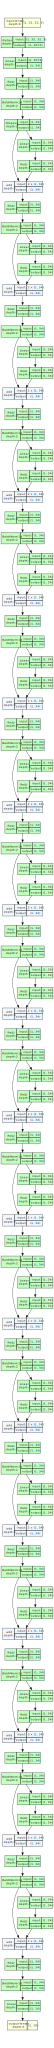

In [23]:
model_graph = draw_graph(model, input_size=(1,)+x_train.shape[1:], device=device, depth=3)
model_graph.visual_graph

In [24]:
predictions = model.predict(x_train[:5].to(device)).cpu().detach().numpy()

predictions

array([[0.08315113, 0.14877973, 0.03536795, 0.05513517, 0.09037255,
        0.2111995 , 0.10512557, 0.16369368, 0.04374569, 0.06342908],
       [0.03783135, 0.03098263, 0.06004908, 0.05601747, 0.2747857 ,
        0.081062  , 0.17056733, 0.02373629, 0.19793798, 0.06703015],
       [0.05520316, 0.07313856, 0.10841249, 0.17294699, 0.02919458,
        0.07393397, 0.16355078, 0.08729256, 0.09768953, 0.13863742],
       [0.09666584, 0.11491855, 0.09163556, 0.14828074, 0.07009412,
        0.0518223 , 0.02491534, 0.14055397, 0.09169884, 0.16941474],
       [0.28896922, 0.08580715, 0.15170224, 0.06330177, 0.05334846,
        0.16528392, 0.04196903, 0.06967957, 0.03682662, 0.04311201]],
      dtype=float32)

In [25]:
model.model_loss(model(x_train[:5].to(device)),
                 y_train[:5].to(device)
                ).cpu().detach().numpy()

array(2.7867432, dtype=float32)

In [26]:
model.model_acc(model(x_train[:5].to(device)),
                y_train[:5].to(device)).cpu().detach().numpy()

array(0.2, dtype=float32)

In [27]:
xy_train = torch.utils.data.DataLoader(list(zip(x_train, y_train)),
                                       shuffle=True,
                                       batch_size=250,
                                       num_workers=cfg_num_workers) # Using CFG

xy_val = torch.utils.data.DataLoader(list(zip(x_val, y_val)),
                                     shuffle=False,
                                     batch_size=250,
                                     num_workers=cfg_num_workers) # Using CFG

xy_test = torch.utils.data.DataLoader(list(zip(x_test, y_test)),
                                      shuffle=False,
                                      batch_size=250,
                                      num_workers=cfg_num_workers) # Using CFG

In [28]:
# Setup Logger
logger = pl.loggers.CSVLogger("logs", name="OL2", version="resid")

In [29]:
trainer = pl.Trainer(logger=logger,
                     max_epochs=cfg_max_epochs,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=20)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [30]:
# Validate on Model
trainer.validate(model, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.09650000184774399    │
│         val_loss          │    2.3589260578155518     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.09650000184774399, 'val_loss': 2.3589260578155518}]

In [31]:
trainer.fit(model, xy_train, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | module     | ResidualNetwork    | 127 K 
1 | model_acc  | MulticlassAccuracy | 0     
2 | model_loss | CrossEntropyLoss   | 0     
--------------------------------------------------
127 K     Trainable params
0         Non-trainable params
127 K     Total params
0.510     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [32]:
# Validate on Model
trainer.validate(model, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.4415000081062317     │
│         val_loss          │     1.552427887916565     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.4415000081062317, 'val_loss': 1.552427887916565}]

In [33]:
results = pd.read_csv(logger.log_dir+"/metrics.csv")
results

,val_acc,val_loss,epoch,step,train_acc,train_loss
0,0.0965,2.358926,0,0,NaN,NaN
1,0.2444,2.033589,0,159,NaN,NaN
2,NaN,NaN,0,159,0.178125,2.185608
3,0.3073,1.905700,1,319,NaN,NaN
4,NaN,NaN,1,319,0.268775,1.977233
...,...,...,...,...,...,...
97,0.4288,1.577550,48,7839,NaN,NaN
98,NaN,NaN,48,7839,0.430900,1.569022
99,0.4415,1.552428,49,7999,NaN,NaN
100,NaN,NaN,49,7999,0.430200,1.568198


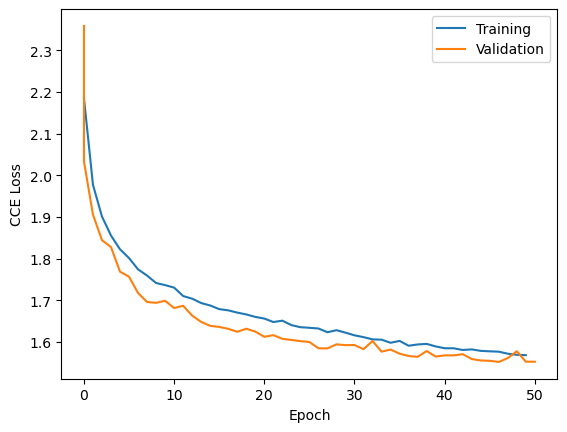

In [34]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")

plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))],
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))],
         label="Validation")

plt.legend()
plt.ylabel("CCE Loss")
plt.xlabel("Epoch")
plt.show()

In [35]:
print("Validation accuracy:",*["%.8f"%(x) for x in results['val_acc'][np.logical_not(np.isnan(results["val_acc"]))]])

Validation accuracy: 0.09650000 0.24439999 0.30730000 0.31920001 0.32820001 0.36399999 0.37400001 0.38229999 0.39359999 0.38810000 0.38970000 0.39420000 0.38820001 0.40070000 0.40099999 0.41090000 0.41380000 0.40669999 0.41010001 0.41200000 0.41420001 0.42140001 0.41339999 0.42609999 0.42230001 0.42379999 0.42420000 0.42670000 0.43259999 0.42809999 0.42490000 0.42660001 0.43030000 0.42260000 0.43610001 0.43040001 0.42860001 0.43189999 0.43830001 0.43250000 0.43430001 0.43570000 0.43900001 0.42840001 0.43579999 0.44020000 0.44069999 0.44650000 0.44350001 0.42879999 0.44150001 0.44150001


In [36]:
print("Testing accuracy:", trainer.test(model, xy_test)[0]['test_acc'])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4447000026702881     │
│         test_loss         │    1.5519952774047852     │
└───────────────────────────┴───────────────────────────┘

Testing accuracy: 0.4447000026702881
